<a href="https://colab.research.google.com/github/ss-ghule/misc_or_test_repo/blob/master/celeb_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN







In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

In [4]:
tf.__version__

'2.0.0-beta1'

In [0]:
!pip install -q imageio

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from tensorflow.keras import layers
import time
from IPython import display
from tqdm import tqdm

## Load Data

In [7]:
%env KAGGLE_CONFIG_DIR=/content
!echo $KAGGLE_CONFIG_DIR
!kaggle datasets download -d jessicali9530/celeba-dataset

env: KAGGLE_CONFIG_DIR=/content
/content
100% 1.21G/1.21G [00:17<00:00, 18.9MB/s]
100% 1.21G/1.21G [00:17<00:00, 73.8MB/s]


In [8]:
!unzip celeba-dataset.zip

Archive:  celeba-dataset.zip
  inflating: list_attr_celeba.csv    
  inflating: img_align_celeba.zip    
  inflating: list_landmarks_align_celeba.csv  
  inflating: list_bbox_celeba.csv    
  inflating: list_eval_partition.csv  


In [0]:
!unzip img_align_celeba.zip

In [0]:
images_list=os.listdir('img_align_celeba')

In [15]:
num_images=len(images_list)
print(num_images)

202599


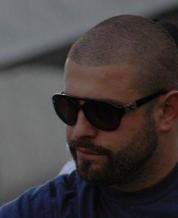

In [63]:
num=np.random.randint(0,num_images)
display.display(Image.open(os.path.join('img_align_celeba',images_list[num])))

In [0]:
image_size=(64,64,3)

In [0]:
sample_size=10000
train_data_dim=(sample_size,)+image_size

In [0]:
def norm_img(img):
    img = (img / 127.5) - 1
    return img

def denorm_img(img):
    img = (img + 1) * 127.5
    return tf.cast(img,tf.uint8) 

In [0]:
def create_train_data(img_dir,image_size,dim):
  data=np.empty(dim,dtype=np.float32)
  for index,img_file_name in enumerate(tqdm(os.listdir(img_dir)[:sample_size])):
    img=Image.open(os.path.join(img_dir,img_file_name))
    img = img.resize(image_size[:-1])
    img=np.asarray(img)
    data[index]=norm_img(img)
  return data

In [66]:
train_images=create_train_data('img_align_celeba',image_size,train_data_dim)

100%|██████████| 10000/10000 [00:09<00:00, 1012.98it/s]


In [0]:
import gc
gc.collect()
#del train_images

In [67]:
train_images.shape

(10000, 64, 64, 3)

In [68]:
print(train_images.min())
print(train_images.max())

-1.0
1.0


In [0]:
#normalize images
#train_images=(train_images-127.5)/127.5
#train_images=train_images/255

W0822 18:39:53.381309 139995472553856 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


577


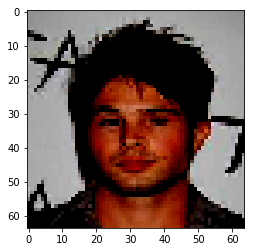

In [77]:
num=np.random.randint(0,sample_size)
print(num)
plt.imshow(train_images[num])

In [0]:
BUFFER_SIZE=10000
BATCH_SIZE=256

In [0]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator

In [0]:
def make_generator_model():
  model=tf.keras.Sequential()
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8,8,256)))
  
  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
  assert model.output_shape == (None, 8, 8, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape == (None, 16, 16, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(32,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape == (None, 32, 32, 32)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
  assert model.output_shape == (None, 64, 64, 3)

  return model

W0822 18:12:19.430572 139995472553856 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.030349426
0.030097976


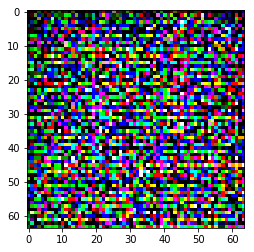

In [28]:
generator=make_generator_model()

noise=tf.random.normal([1,100])
generated_image=generator(noise,training=False)
print(np.min(generated_image))
print(np.max(generated_image))
plt.imshow(generated_image[0]*255)

## Discriminator

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [30]:
discriminator=make_discriminator_model()
decision=discriminator(generated_image)
print(decision)

tf.Tensor([[0.00108732]], shape=(1, 1), dtype=float32)


## Loss and Optimizers

In [0]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_loss
  return total_loss

In [0]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [0]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

## Save checkpoints

In [0]:
checkpoint_dir='./celeb_training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                               generator=generator,
                               discriminator=discriminator)

In [36]:
checkpoint_prefix

'./celeb_training_checkpoints/ckpt'

## Training loop Definition

In [0]:
EPOCHS=5
noise_dim=100
num_example_to_generate=16
seed=tf.random.normal([num_example_to_generate,noise_dim])

In [38]:
seed

<tf.Tensor: id=999, shape=(16, 100), dtype=float32, numpy=
array([[ 6.1797822e-01, -4.0843356e-01, -1.2625073e+00, ...,
         5.2009559e-01,  1.1957730e+00, -2.3780930e-01],
       [-5.3475124e-01, -1.1364408e+00,  1.4319419e+00, ...,
        -3.9302582e-01,  1.8239417e+00, -4.3789428e-01],
       [ 2.1184078e-01, -1.2646072e+00, -2.9573369e-01, ...,
         2.1093903e+00, -1.0035214e+00,  1.0932130e+00],
       ...,
       [-1.8011616e-01, -4.5677322e-01, -2.1666596e+00, ...,
        -6.5634668e-01,  2.0504899e+00,  7.4550412e-03],
       [-1.6522607e-01,  2.9665345e-01, -6.8575579e-01, ...,
         1.1561426e+00,  1.8623966e+00, -9.4193973e-02],
       [ 9.6706836e-04,  5.3045207e-01, -1.4642291e-01, ...,
         2.1885138e+00,  2.6106453e+00,  1.4884273e+00]], dtype=float32)>

In [0]:
@tf.function
def train_step(images):
  noise=tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images=generator(noise,training=True)

    images=tf.cast(images,tf.float32)
    generated_images=tf.cast(generated_images,tf.float32)
    real_output=discriminator(images,training=True)
    fake_output=discriminator(generated_images,training=True)

    gen_loss=generator_loss(fake_output)
    disc_loss=discriminator_loss(real_output,fake_output)

  gradients_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradients_of_discriminator=disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [0]:
def train(dataset,epochs):
  for epoch in range(epochs):
    start=time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch+1,seed)

    if (epoch+1)%15==0:
      checkpoint.save(file_prefix=checkpoint_prefix)
    print('Time for epoch {} is {} sec'.format(epoch+1,time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

In [0]:
!mkdir celeb_training_images

In [0]:
def generate_and_save_images(model,epoch,test_input):
  predictions=model(test_input,training=False)
  fig=plt.figure(figsize=(8,8))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    #plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
    #plt.imshow(predictions[i,:,:,2]*255,cmap='gray')
    plt.imshow(denorm_img(predictions[i]))
    plt.axis('off')

  plt.savefig('celeb_training_images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Training

In [83]:
%%time
EPOCHS=10000
train(train_dataset,EPOCHS)

Buffered data was truncated after reaching the output size limit.

In [0]:
!ls

In [0]:
from PIL import Image

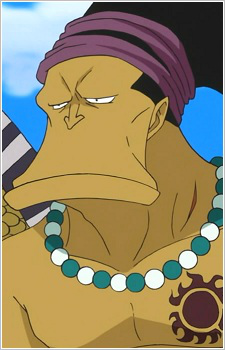

In [0]:
img=Image.open('501.jpg')
display.display(img)